# The arXiv NLP Project - Part 2

## Packages

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.4.1'

In [3]:
np.random.seed(42)
sns.set()

## Paths & Config

In [4]:
DATA_SET = "./data/clean-arXiv-1000-sample.json"
# MAX_WORDS = 1000
# MAX_LEN = 30

VALIDATION_SPLIT = 0.2


# EMBBEDING_DIM = 50

# BATCH_SIZE = 32
# LEARNING_RATE = 1e-3
# EPOCHS = 10

## 1. Get Data

In [5]:
data = pd.read_json(DATA_SET, orient="records")
data.head(10)

,id,authors,title,category,abstract,title_length,abstract_length
0,2101.01590,"Matyas Barczy, Gyula Pap",Mixing convergence of LSE for supercritical Ga...,math,We prove mixing convergence of least squares...,12,58
1,2101.01590,"Matyas Barczy, Gyula Pap",Mixing convergence of LSE for supercritical Ga...,stat,We prove mixing convergence of least squares...,12,58
2,2106.05427,Sibo Cheng and Didier Lucor and Jean-Philippe ...,Observation data compression for variational a...,math,Accurate estimation of error covariances (bo...,9,181
3,2106.05427,Sibo Cheng and Didier Lucor and Jean-Philippe ...,Observation data compression for variational a...,cs,Accurate estimation of error covariances (bo...,9,181
4,2107.06669,"Yong Chen, Young Joo Lee, Yile Zhao",Complex symmetry of Toeplitz operators,math,We introduce a new class of conjugations and...,5,63
5,1810.05664,Khaled Bahlali and Ludovic Tangpi,BSDEs driven by $|z|^2/y$ and applications to ...,math,Existence and uniqueness is established for ...,11,158
6,2102.00196,Karn Watcharasupat and Anh H. T. Nguyen and Ch...,Directional Sparse Filtering using Weighted Le...,eess,In blind source separation of speech signals...,14,74
7,2102.00196,Karn Watcharasupat and Anh H. T. Nguyen and Ch...,Directional Sparse Filtering using Weighted Le...,cs,In blind source separation of speech signals...,14,74
8,2109.13300,"Sophie Crisp, Alexander Ody, Pietro Musumeci, ...",Resonant phase matching by oblique illuminatio...,physics,In dielectric laser-driven accelerators (DLA...,11,161
9,2101.11067,"Sufian Abedrabbo (1 and 2), Bashar Lahlouh (2)...",Optical polarizability of erbium-oxygen comple...,physics,"For erbium-doped amorphous oxides, such as t...",9,201


## 2. Prepare Data

In [6]:
n_samples = len(data)
print("Total samples: ", n_samples)

Total samples:  1437


In [7]:
num_classes = data["category"].nunique()

### Normalization

In [8]:
def norm(text):
    text = text.lower()
    for char in "0123456789_-()[]{}.,;:!$%~&|\^@°/*-+=":
        text = text.replace(char, '')
    return text

data['title'] = data['title'].apply(norm)
data['abstract'] = data['abstract'].apply(norm)
data.head()

,id,authors,title,category,abstract,title_length,abstract_length
0,2101.01590,"Matyas Barczy, Gyula Pap",mixing convergence of lse for supercritical ga...,math,we prove mixing convergence of least squares...,12,58
1,2101.01590,"Matyas Barczy, Gyula Pap",mixing convergence of lse for supercritical ga...,stat,we prove mixing convergence of least squares...,12,58
2,2106.05427,Sibo Cheng and Didier Lucor and Jean-Philippe ...,observation data compression for variational a...,math,accurate estimation of error covariances bot...,9,181
3,2106.05427,Sibo Cheng and Didier Lucor and Jean-Philippe ...,observation data compression for variational a...,cs,accurate estimation of error covariances bot...,9,181
4,2107.06669,"Yong Chen, Young Joo Lee, Yile Zhao",complex symmetry of toeplitz operators,math,we introduce a new class of conjugations and...,5,63


In [9]:
texts = data['abstract']
labels = data["category"]

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

label_encoder = LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels).reshape(-1, 1)

one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(labels)
labels = one_hot_encoder.transform(labels).toarray()

# pipeline = Pipeline([("label_encoder", LabelEncoder()), ("one_hot_encoder", OneHotEncoder())])
# pipeline.fit(labels)
# y = pipeline.transform(labels)
# y.shape

In [11]:
len(set(" ".join(list(texts)).split()))

15249

### Tokenization

In [12]:
MAX_WORDS = 1000
MAXLEN = 50

In [13]:
# Tokenization
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)

### Vectorization

In [14]:
# Vectorization
sequences = tokenizer.texts_to_sequences(texts)
X = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAXLEN)
X.shape

(1437, 50)

## 4. Sample Data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, stratify=labels, test_size=VALIDATION_SPLIT)

## Design model

In [23]:
EMBBEDING_DIM = 64

In [37]:
def build_model():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(MAX_WORDS, EMBBEDING_DIM, input_length=MAXLEN))
    model.add(keras.layers.LSTM(32, return_sequences=True))
    # model.add(keras.layers.LSTM(32, return_sequences=True))
    # model.add(keras.layers.LSTM(32, return_sequences=True))
    model.add(keras.layers.GlobalAveragePooling1D(name="features"))
    # model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu'))
    # model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(num_classes, activation='softmax', name="outputs"))
    
    return model

model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 64)            64000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 32)            12416     
_________________________________________________________________
features (GlobalAveragePooli (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
outputs (Dense)              (None, 20)                1300      
Total params: 79,828
Trainable params: 79,828
Non-trainable params: 0
_________________________________________________________________


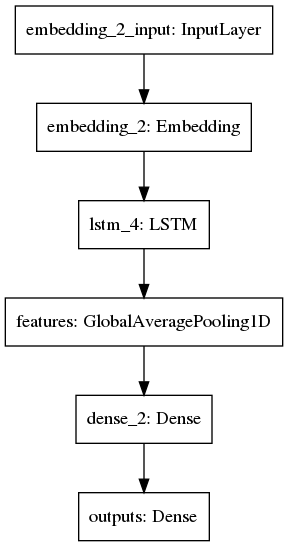

In [38]:
# !pip install pydot
# !conda install graphviz -y
keras.utils.plot_model(model)

## Loss & Optimizer

In [39]:
LEARNING_RATE = 1.5e-3

In [40]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=LEARNING_RATE),
              metrics=["accuracy"])

## Train model

In [41]:
BATCH_SIZE = 64
EPOCHS = 15

In [42]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE , epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/15
18/18 [==============================] - 32s 581ms/step - loss: 2.9552 - accuracy: 0.2585 - val_loss: 2.5586 - val_accuracy: 0.2917
Epoch 2/15
18/18 [==============================] - 5s 283ms/step - loss: 2.4995 - accuracy: 0.2750 - val_loss: 2.3431 - val_accuracy: 0.2917
Epoch 3/15
18/18 [==============================] - 5s 286ms/step - loss: 2.3165 - accuracy: 0.2879 - val_loss: 2.2891 - val_accuracy: 0.2917
Epoch 4/15
18/18 [==============================] - 5s 292ms/step - loss: 2.2300 - accuracy: 0.2822 - val_loss: 2.1682 - val_accuracy: 0.2951
Epoch 5/15
18/18 [==============================] - 5s 281ms/step - loss: 2.0201 - accuracy: 0.3210 - val_loss: 2.0654 - val_accuracy: 0.4062
Epoch 6/15
18/18 [==============================] - 5s 279ms/step - loss: 1.8873 - accuracy: 0.4152 - val_loss: 1.9965 - val_accuracy: 0.3889
Epoch 7/15
18/18 [==============================] - 5s 289ms/step - loss: 1.7379 - accuracy: 0.4582 - val_loss: 1.9922 - val_accuracy: 0.4271
Epoch

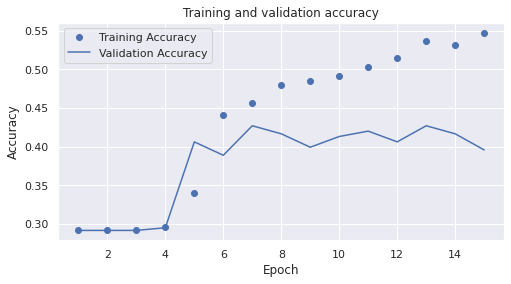

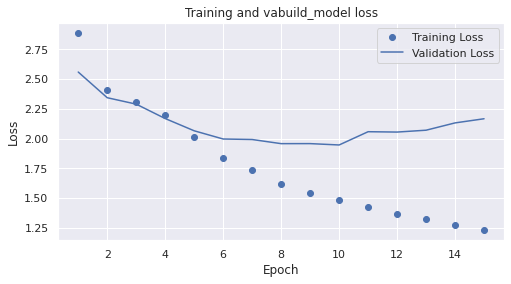

In [43]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

## Evaluate model

In [44]:
y_pred = model(X_test)
y_pred = np.argmax(y_pred, axis=1)

print("Accuracy score:", accuracy_score(np.argmax(y_test, axis=1), y_pred))

Accuracy score: 0.3958333333333333


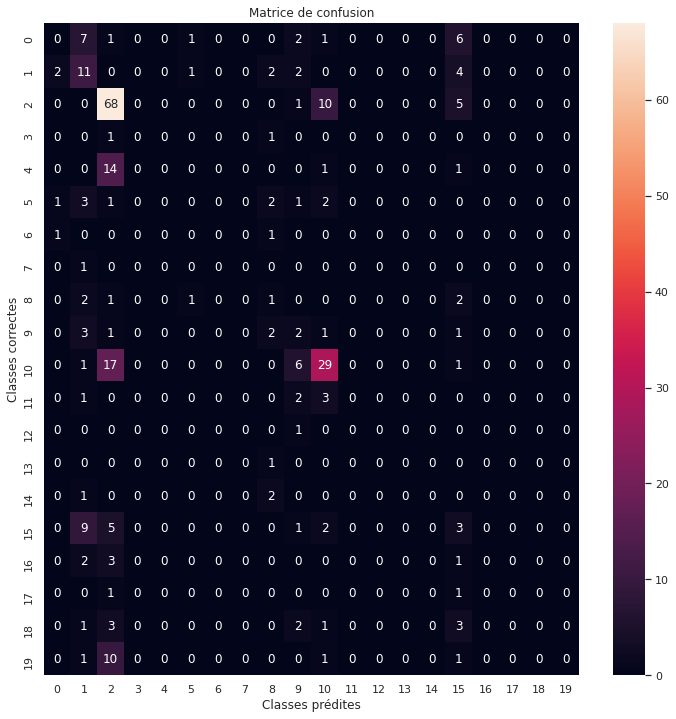

In [45]:
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_mat, annot=True, fmt="d", cbar=True)
plt.title("Matrice de confusion")
plt.xlabel("Classes prédites")
plt.ylabel("Classes correctes")
plt.show()

## Save model

In [46]:
model.save(SAVE_MODEL_PATH)

NameError: name 'SAVE_MODEL_PATH' is not defined